
# Uplift Modeling with Criteo Dataset

## Introduction
This notebook demonstrates how to calculate the Average Treatment Effect (ATE) using meta learners and perform uplift modeling using the Criteo dataset. The Criteo dataset, an advertising dataset, includes user features, treatment indicators, and conversion labels. 

I'll be utilizing CausalML, which is a great library of causal machine learning especially suited for marketing use cases and uplift modeling. 



## 1. About the Dataset

The Criteo dataset used in this analysis is a collection of 13 million samples from a randomized control trial conducted by The Criteo AI Lab. 

### Features Description:
- `f0` to `f11`: Feature values (dense, float)
- `treatment`: Treatment group (1 = treated, 0 = control)
- `conversion`: Whether a conversion occurred for this user (binary, label)
- `visit`: Whether a visit occurred for this user (binary, label)
- `exposure`: Treatment effect, whether the user has been effectively exposed (binary)

In this notebook, we will demonstrate the use of the Uplift RandomForestClassifier on this dataset.

### Paper
“A Large Scale Benchmark for Uplift Modeling”

Eustache Diemert, Artem Betlei, Christophe Renaudin; (Criteo AI Lab), Massih-Reza Amini (LIG, Grenoble INP)

https://ailab.criteo.com/criteo-uplift-prediction-dataset

In [1]:
!pip install causalml

In [2]:
!pip install scikit-uplift

In [3]:

# Import necessary libraries
import numpy as np
import pandas as pd
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, plot_qini
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from IPython.display import display

# Ensure the required libraries are installed
print(importlib.metadata.version('causalml'))


0.15.1


In [4]:
from sklift.datasets import fetch_criteo

X, y, treatment = fetch_criteo(target_col='conversion', treatment_col='treatment', return_X_y_t=True)

df = X.copy()
df['conversion'] = y.astype('int64')
df['treatment'] = treatment.astype('object').replace({0: 'control', 1: 'treatment'})
# df['user_id'] = df.index

df.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,conversion,treatment
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,treatment


## 2. Data Overview

The Criteo dataset consists of 13 million rows and is significantly imbalanced, with approximately 85% treated users who saw the advertisements and 15% non-treated users who didn’t.


In [5]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


In [6]:
df['treatment'].value_counts(normalize = True)

treatment    0.85
control      0.15
Name: treatment, dtype: float64

In [7]:
df['conversion'].value_counts(normalize = True)

0    0.997083
1    0.002917
Name: conversion, dtype: float64

## 3. Conversion Rates

We'll analyze the conversion rates for both groups:
- **Treatment Group:** 0.31% conversion rate (percentage of users who saw the advertisement and made a purchase).
- **Control Group:** 0.19% conversion rate (percentage of users who did not see the advertisement but made a purchase).

**Simply subtracting these rates to determine the advertisement's effect is incorrect** due to the targeted nature of digital advertising.


In [8]:

# Conversion and conversion rate by treatment group
treatment_group = df[df['treatment'] == 'treatment']
control_group = df[df['treatment'] == 'control']

# Number of users and conversion rate in treatment group
treatment_converted = treatment_group['conversion'].sum()
treatment_total = len(treatment_group)
treatment_conversion_rate = treatment_converted / treatment_total

# Number of users and conversion rate in control group
control_converted = control_group['conversion'].sum()
control_total = len(control_group)
control_conversion_rate = control_converted / control_total

# Create a summary table
summary_table = pd.DataFrame({
    '': ['Total Users', 'Converted Users', 'Conversion Rate (%)'],
    'Treatment Group': [treatment_total, treatment_converted, f"{treatment_conversion_rate * 100:.2f}%"],
    'Control Group': [control_total, control_converted, f"{control_conversion_rate * 100:.2f}%"]
})
display(summary_table)

# Difference in conversion rate
conversion_rate_difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference in Conversion Rate between Treatment and Control Groups: {conversion_rate_difference * 100:.2f}% "
      f"(Treatment: {treatment_conversion_rate * 100:.2f}%, Control: {control_conversion_rate * 100:.2f}%)")
print("Note: This is the simple difference in conversion rates and not the true treatment effect.")


,,Treatment Group,Control Group
0,Total Users,11882655,2096937
1,Converted Users,36711,4063
2,Conversion Rate (%),0.31%,0.19%


Difference in Conversion Rate between Treatment and Control Groups: 0.12% (Treatment: 0.31%, Control: 0.19%)
Note: This is the simple difference in conversion rates and not the true treatment effect.


## 4. Calculating ATE with Meta Learners

We'll use meta learners, specifically the XGBT regressor from CausalML, to calculate the Average Treatment Effect (ATE). This model employs XGBoost within the T-learner framework.

The estimated ATE is 0.10%, slightly lower than the simple aggregation result of 0.12%, accounting for customers who would have purchased regardless of seeing the advertisement.


In [9]:
from causalml.inference.meta import XGBTRegressor

# Initialize and fit the T-Learner with XGBoost
learner_t = XGBTRegressor()
learner_t.fit(X=X.values, treatment=treatment.values, y=y.values)

# Predict the treatment effect and calculate the Average Treatment Effect (ATE)
treatment_effect = learner_t.predict(X=X.values)
ate = treatment_effect.mean()

# Output the estimated ATE as a percentage
print(f"Estimated ATE: {ate * 100:.2f}%")


Estimated ATE: 0.10%


## 5. Decomposing Observed Conversion Rates

We'll visualize the relationship between ATE and selection bias. The difference in conversion rates between the treatment and control groups can be decomposed into ATE (the true effect of the advertisement) and selection bias.







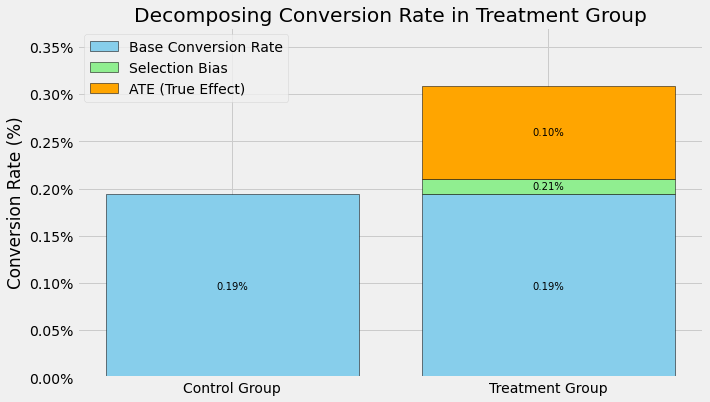

In [10]:
selection_bias = treatment_conversion_rate - ate

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for Treatment Group
base_conversion = control_conversion_rate
selection_bias_height = selection_bias - control_conversion_rate
ate_height = ate

# Create the bar plot
ax.bar('Control Group', control_conversion_rate, color='skyblue', edgecolor='black', label='Base Conversion Rate')
ax.bar('Treatment Group', base_conversion, color='skyblue', edgecolor='black')  # No label to avoid duplication
ax.bar('Treatment Group', selection_bias_height, bottom=base_conversion, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate_height, bottom=base_conversion + selection_bias_height, color='orange', edgecolor='black', label='ATE (True Effect)')

# Adding text labels for each segment
ax.text(0, control_conversion_rate / 2, f'{control_conversion_rate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion / 2, f'{base_conversion * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height / 2, f'{selection_bias * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height + ate_height / 2, f'{ate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)

# Customizing plot
ax.set_ylim(0, treatment_conversion_rate * 1.2)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Decomposing Conversion Rate in Treatment Group')

# Adding legend
ax.legend()

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2f}%'.format(y * 100)))

plt.show()

## 6. Uplift Modeling

### What is Uplift Modeling?

- Uplift modeling answers the question: Who should we target to maximize sales? 
- It helps identify customers who are more likely to buy when treated than when not treated. 

#### Segmentation of Customers

We can categorize customers into one of four types:
- **Persuadables:** Likely to buy only if treated. These are the primary targets for uplift modeling.
- **Sure Things:** Will buy regardless of treatment.
- **Lost Causes:** Will not buy even if treated.
- **Sleeping Dogs:** Less likely to buy if treated.

For cost-effective marketing, focus on Persuadables and avoid giving treatment to Sure Things, Lost Causes, and Sleeping Dogs.

#### Methods for Uplift Modeling

There are two main methods for uplift modeling:
1. **Meta-learner** 
2. **Decision Tree Based Method** 

In this notebook, we use the Decision Tree Based Method for uplift modeling.



### Training the Uplift Model

After splitting the data into training and test sets, we use the Uplift Random Forest to train the model. The training process involves using the `fit` function, and we predict the uplift for test data with the `predict` function. The interface of CausalML is similar to other machine learning libraries.


In [11]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    df.drop(columns = ['conversion', 'treatment']), df['conversion'], df['treatment'],
    test_size=0.3, random_state=42)

# Train Uplift Random Forest model
uplift_rf = UpliftRandomForestClassifier(control_name='control')
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift using the trained model
y_pred = uplift_rf.predict(X_test)


In [12]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_rf.uplift_forest[0]

# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, X_train.columns)

f6treatment_group_key >= -2.411114577488788?
yes -> f8treatment_group_key >= 3.858040606974631?
		yes -> f0treatment_group_key >= 26.493608540226706?
				yes -> f8treatment_group_key >= 3.9026446385483897?
						yes -> [0.0, 8.994018977380042e-05]
						no  -> [0.0, 0.002007456266131345]
				no  -> f0treatment_group_key >= 26.16941538711941?
						yes -> [0.0, 5.9314219775360876e-05]
						no  -> [0.0002896155510958958, 0.00045954408344798283]
		no  -> f0treatment_group_key >= 22.218737296181708?
				yes -> f11treatment_group_key >= -0.1686792210005612?
						yes -> [0.004137537451847625, 0.004905012075791151]
						no  -> [0.1282051282051282, 0.060265166733627966]
				no  -> f2treatment_group_key >= 8.660104385126353?
						yes -> [0.0017366136034732273, 0.0012051033507112729]
						no  -> [0.009021097394822675, 0.012072999532054282]
no  -> f2treatment_group_key >= 8.630155350439548?
		yes -> f4treatment_group_key >= 11.561050451496424?
				yes -> f0treatment_group_key >= 20.978013224

### Visualization

CausalML allows visualization of the tree structure.


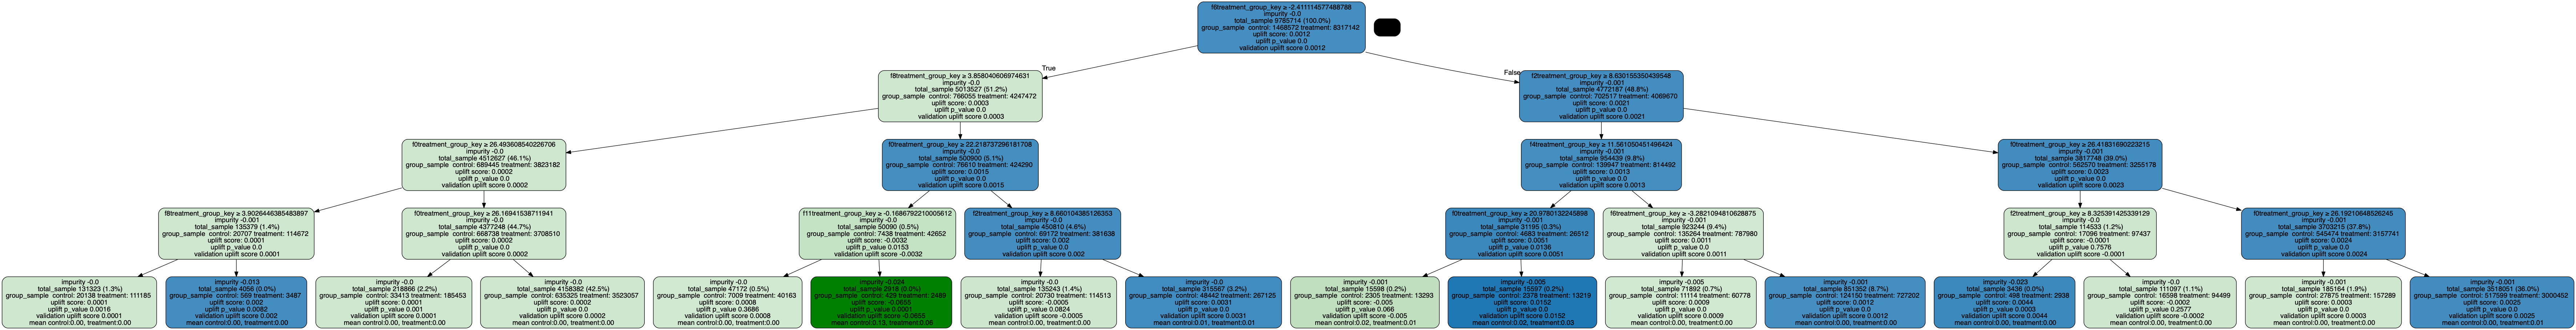

In [13]:
# Plot uplift tree
from IPython.display import Image
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

### Feature Importance

We can display feature importance to understand which variables significantly impact the model's predictions. 


<AxesSubplot:>

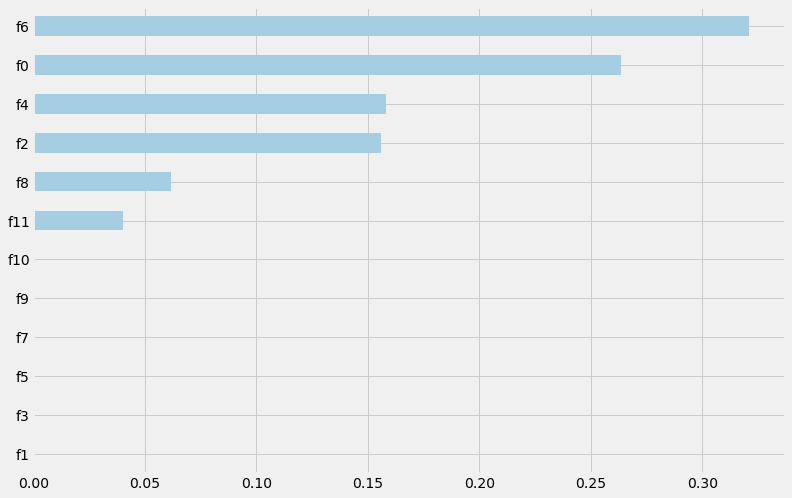

In [14]:
# Plotting the feature importance of the uplift tree
pd.Series(uplift_tree.feature_importances_, index = X_train.columns).sort_values().plot(kind='barh', figsize=(12,8))


### Preparation for Evaluation

To prepare for evaluation, create a dataframe with columns for `is_treated`, `conversion`, and `uplift` for each user. Positive uplift indicates the advertisement is beneficial, while negative uplift suggests it’s better not to show the advertisement.


In [15]:
uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results['treatment'] < 0, 'control', 'treatment')

auuc_metrics = (uplift_results.assign(is_treated=(treatment_test.values != 'control').astype(int),
                              conversion=pd.concat([X_test, y_test, treatment_test], axis=1)['conversion'].values,
                              uplift=uplift_results.max(axis=1))
                .drop(columns=list(uplift_rf.classes_[1:])))

# Print AUUC metrics DataFrame
print("AUUC metrics DataFrame:")
display(auuc_metrics)


AUUC metrics DataFrame:


,is_treated,conversion,uplift
0,0,0,0.001262
1,1,0,0.001086
2,1,0,0.000343
3,1,0,0.000343
4,1,0,0.000232
...,...,...,...
4193873,0,0,0.000371
4193874,1,0,0.000431
4193875,1,0,0.000343
4193876,1,0,0.000433


### Uplift Curve: Total Cumulative Gain

The Uplift Curve helps us understand the Total Cumulative Gain. It shows how effectively the model targets users likely to convert upon seeing the ads. The light-blue curved line represents the uplift modeling approach, and the blue line indicates a random approach for comparison. Targeting 20% of the total population can achieve 80% of the results of targeting everyone. The area between the two lines is called the AUUC: Area Under the Uplift Curve score.


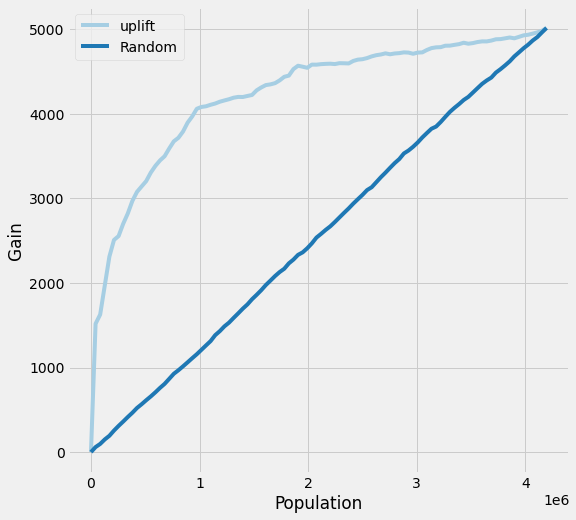

In [16]:
# Plot the uplift curve
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

### AUUC (Area Under the Uplift Curve) Score

AUUC is a metric for evaluating uplift modeling performance, similar to AUC (Area Under the ROC Curve). A score near 1 is excellent, while a score near 0.5 indicates no better performance than random guessing. In this case, the AUUC score is 0.87, indicating good performance.



In [17]:
from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.844375
Random    0.506221
dtype: float64


### Extracting Targeted Users

Finally, we extract a list of customers to target based on their uplift scores, calculating the decile for each customer. By exporting this list, you can determine whom to target according to your budget.

In [18]:
# Sort the uplift_results DataFrame by 'uplift' in descending order
uplift_results['user_id'] = X_test.index
uplift_results.rename(columns={'treatment': 'uplift'}, inplace=True)
uplift_results_sorted = uplift_results.sort_values(by='uplift', ascending=False).reset_index(drop=True)

# Print the customer list
print("Customer List Sorted by Uplift:")
display(uplift_results_sorted[['user_id', 'uplift']].head(10))

Customer List Sorted by Uplift:


,user_id,uplift
0,5522331,0.095828
1,405008,0.095828
2,5345387,0.095828
3,1846106,0.082823
4,3453051,0.082823
5,5422016,0.082228
6,5310353,0.079992
7,1924941,0.079992
8,3523409,0.079992
9,3906973,0.079992


In [19]:
# Calculate Rank and Decile Label
uplift_results_sorted['rank'] = uplift_results_sorted['uplift'].rank(method='first', ascending=False)
uplift_results_sorted['decile'] = pd.qcut(uplift_results_sorted['rank'], 10, labels=False)

decile_labels = [
    "top 10%", "top 10%-20%", "top 20%-30%", "top 30%-40%", "top 40%-50%", 
    "top 50%-60%", "top 60%-70%", "top 70%-80%", "top 80%-90%", "bottom 10%"
]

column_order = ['user_id', 'uplift', 'rank', 'decile', 'decile_label']
uplift_results_sorted['decile_label'] = uplift_results_sorted['decile'].map(lambda x: decile_labels[x])
display(uplift_results_sorted[column_order].head(10))


uplift_results_sorted[column_order].to_csv('customer_list_sorted_by_uplift.csv', index=False)

print("Customer list has been saved to 'customer_list_sorted_by_uplift.csv'")


,user_id,uplift,rank,decile,decile_label
0,5522331,0.095828,1.0,0,top 10%
1,405008,0.095828,2.0,0,top 10%
2,5345387,0.095828,3.0,0,top 10%
3,1846106,0.082823,4.0,0,top 10%
4,3453051,0.082823,5.0,0,top 10%
5,5422016,0.082228,6.0,0,top 10%
6,5310353,0.079992,7.0,0,top 10%
7,1924941,0.079992,8.0,0,top 10%
8,3523409,0.079992,9.0,0,top 10%
9,3906973,0.079992,10.0,0,top 10%


Customer list has been saved to 'customer_list_sorted_by_uplift.csv'



## 7. Conclusion
In this notebook, I demonstrated how to measure treatment effect and run uplift modeling using the Criteo dataset and CausalML.
